In [1]:
import pandas as pd

In [2]:
from nltk.tokenize import word_tokenize

In [3]:
import spacy

In [4]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

In [5]:
data_j=pd.read_json('D:\\Internships\\Heuro\\final.json',lines=True,orient='records')

In [6]:
data_j.head()

,document,annotation
0,"The house plan has two bedrooms, two washrooms...","[{'start': 19, 'end': 22, 'label': 'QUANT', 't..."
1,"House has one washroom, one livingroom, one st...","[{'start': 10, 'end': 13, 'label': 'QUANT', 't..."
2,"House has three bedrooms, one washroom, one ba...","[{'start': 10, 'end': 15, 'label': 'QUANT', 't..."
3,"Building layout contains two bedrooms, one was...","[{'start': 25, 'end': 28, 'label': 'QUANT', 't..."
4,"Building layout contains three bedrooms, two w...","[{'start': 25, 'end': 30, 'label': 'QUANT', 't..."


In [7]:
data_j.shape

(50, 2)

In [8]:
data=pd.read_csv('D:\\Internships\\Heuro\\final.csv')

In [9]:
data.head()

,document,annotation__start,annotation__end,annotation__label,annotation__text
0,"The house plan has two bedrooms, two washrooms...",19,22,QUANT,two
1,NaN,23,31,ROOM,bedrooms
2,NaN,33,36,QUANT,two
3,NaN,37,46,ROOM,washrooms
4,NaN,48,51,QUANT,two


In [10]:
data_new=data[data['annotation__label']=='CONNECTION']['annotation__text']

In [11]:
data_new=data_new.reset_index()

In [12]:
data_new=data_new.drop([106, 146, 142, 183])

In [13]:
data_new=data_new.reset_index()

In [14]:
data_new.head()

,level_0,index,annotation__text
0,0,33,"bedroom1, bedroom2, kitchen1, balcony1, washro..."
1,1,34,"bedroom1 is adjacent to balcony1, washroom1"
2,2,35,"bedroom2 is next to washroom2, balcony2"
3,3,36,kitchen1 is adjacent to balcony2
4,4,37,washroom2 and washroom1 are connected


In [15]:
data_new.shape

(185, 3)

In [16]:
data_new['annotation__text'][0]

'bedroom1, bedroom2, kitchen1, balcony1, washroom1, washroom2, balcony2 and livingroom1 are connected'

In [17]:
from spacy.matcher import Matcher
def pattern(text):
    text_tokens = nlp(text)
    tokens_without_sw= [word for word in text_tokens if not word.is_stop or word.text=='next']
    tokens_without_sw=[token for token in tokens_without_sw if not token.is_punct | token.is_space]
    tokns_without_sw = ' '.join(map(str, tokens_without_sw))
    tokns_without_sw = nlp(tokns_without_sw)
    
    pattern1 = [{'ORTH': 'connected'}]
    pattern2 = [{'ORTH': 'adjacent'}]
    pattern3 = [{'ORTH': 'next'}]
    
    matcher1 = Matcher(nlp.vocab)
    matcher2 = Matcher(nlp.vocab)
    matcher3 = Matcher(nlp.vocab)
    matcher1.add("connected",None, pattern1)
    matcher2.add("adjacent",None, pattern2)
    matcher3.add("next",None, pattern3)
    
    matches1 = matcher1(tokns_without_sw)
    matches2 = matcher2(tokns_without_sw)
    matches3 = matcher3(tokns_without_sw)
    if len(matches1)>=1:
        l=matches1[0][1]
        tabl_arr=[]
        for i in range(l-1):
            for j in range(i+1,l):
                tabl_arr.append({'Room type':tokns_without_sw[i], 'Link': tokns_without_sw[j]})
    
    elif len(matches2)>=1 or len(matches3)>=1:
        
        tabl_arr=[]
        j=0
        tok=word_tokenize(tokns_without_sw.text)
        if 'adjacent' in tok:
            tok.remove('adjacent')
            s=matches2[0][1]
            e=matches2[0][2]
        elif 'next' in tok:
            tok.remove('next')
            s=matches3[0][1]
            e=matches3[0][2]
        tokns_without_sw=nlp(' '.join(map(str, tok)))
        for i in range(1,len(tokns_without_sw)):
            tabl_arr.append({'Room type':tokns_without_sw[0], 'Link': tokns_without_sw[i]})
        
    tabl=pd.DataFrame(tabl_arr)
    return tabl

In [18]:
def concat(pat,patt):
    ta=pd.concat([pat,patt],ignore_index=True)
    t=ta.drop_duplicates(subset=['Room type'] and ['Link'],keep=False)
    for i in t.index:
        if i==0:
            continue
        ta=ta.drop(index=[i])
    return ta

In [19]:
k=[]
table=pattern(data_new['annotation__text'][0])
for i in range(len(data_new['index'])-1):
    if data_new['index'][i+1] == data_new['index'][i]+1:
        if i+1 < len(data_new['index']):
            table=concat(table,pattern(data_new['annotation__text'][i+1]))
    else:
        k.append(table)
        table=pattern(data_new['annotation__text'][i+1])

In [20]:
k[47]

,Room type,Link
0,bedroom1,bedroom2
1,bedroom1,study1
2,bedroom1,kitchen1
3,bedroom1,balcony1
4,bedroom1,washroom1
5,bedroom1,livingroom1
6,bedroom2,study1
7,bedroom2,kitchen1
8,bedroom2,balcony1
9,bedroom2,washroom1


In [21]:
import networkx as nx

In [22]:
G = nx.from_pandas_edgelist(k[26], 'Room type', 'Link')

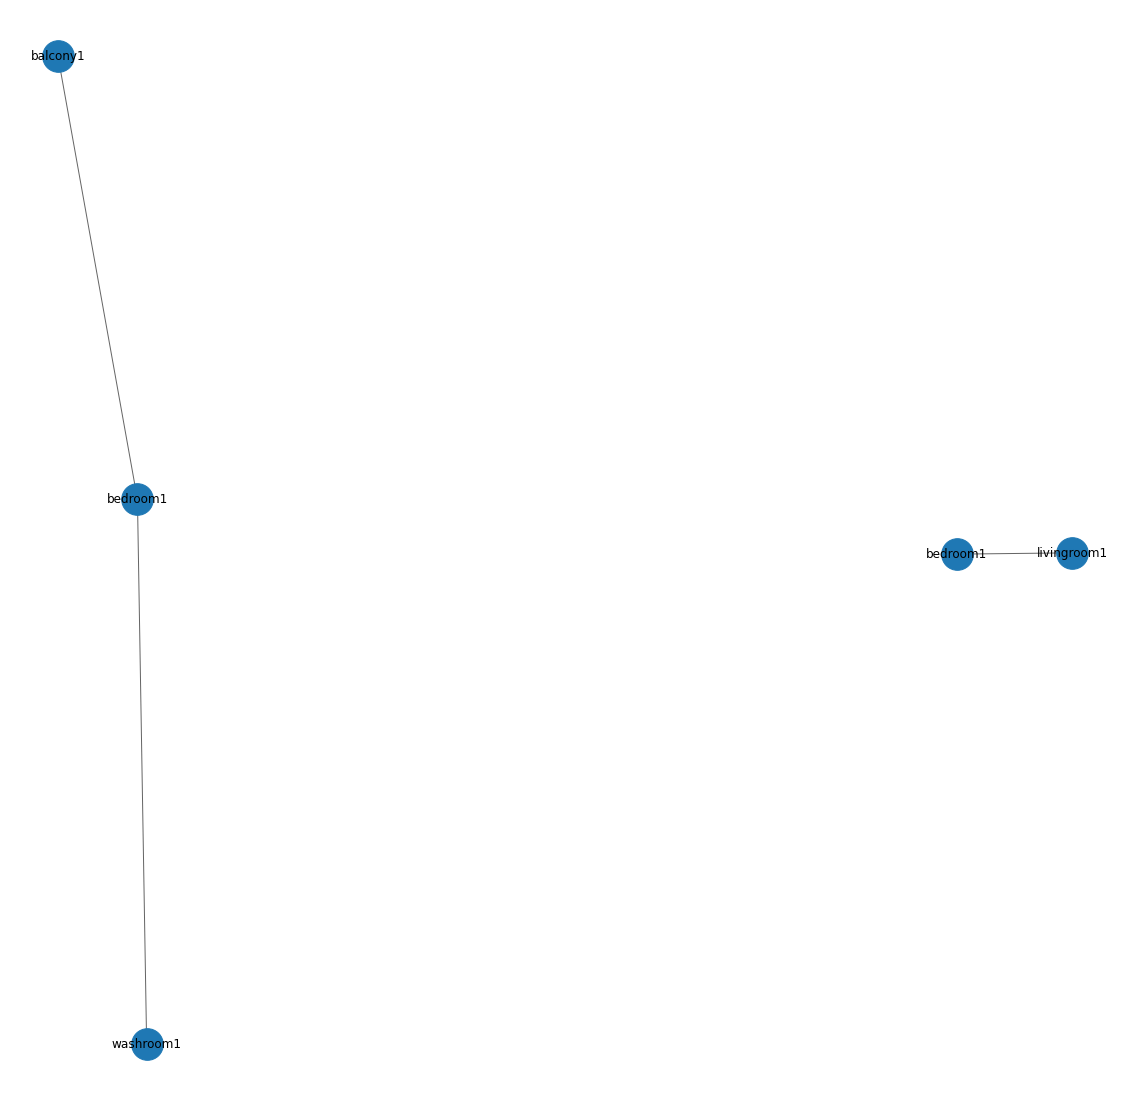

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.axis('off')
nx.draw_networkx(G, node_size = 1000,
                 with_labels = True, edge_color ='.4', cmap = plt.cm.Blues)